In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive')

Mounted at /content/gdrive


In [ ]:
#importing necessary libraries

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher

The web-scraped images are stored in a directory - 'data_scraping' in 6 sub-directories. Using ImageDataGenerator from tensorflow, Splitting the dataset into training set and validation set, preprocessing them by resizing, scaling and data augmentation of only training set.

In [ ]:
# Preprocess images to a standard height and width
# Rescale the images
# AUGMENT THE IMAGES WITH SHEARING, ZOOMING and random rotation


img_height = 256
img_width = 256
channels = 3
batch_size = 16
train_directory= '/content/gdrive/MyDrive/new_train_directory'
validation_directory='/content/gdrive/MyDrive/new_valid_directory'

train_datagen = ImageDataGenerator(rotation_range=40, #random rotation
                                 rescale=1./255, # rescaling (normalizing)
                                   shear_range=0.2,#shearing
                                   zoom_range=0.2, #zooming
                                   #horizontal_flip=True,
                                   fill_mode='nearest',
                                   )
validation_datagen= ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_directory,
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     shuffle=True)

validation_set = validation_datagen.flow_from_directory(validation_directory,
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     shuffle=False)

Found 1448 images belonging to 6 classes.
Found 311 images belonging to 6 classes.


In [ ]:
os.getcwd()

'/content/gdrive/MyDrive'

Developing a convolutional autoencoder from scratch, latent space and decoder.

In [ ]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)



encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)


encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)



encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)


In [ ]:
# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

In [ ]:
# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)


decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)


In [ ]:
# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Model Summary
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_8 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 4194304)           0         
                                                                 
 latent_space (Dense)        (None, 16)                67108880  
                                                       

In [ ]:
# Compile the model WITH MEAN SQUARE ERROR LOSS
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))

In [ ]:
# Fit the model
history = autoencoder.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=10,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h2', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])

# Save model
autoencoder.save('models/image_autoencoder_2.h2')

<ipython-input-16-e874a2cbf087>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


Epoch 1/10
90/90 [==============================] - 403s 4s/step - loss: 0.0674 - val_loss: 0.0910
Epoch 2/10
90/90 [==============================] - 37s 410ms/step - loss: 0.0473 - val_loss: 0.0688
Epoch 3/10
90/90 [==============================] - 38s 421ms/step - loss: 0.0410 - val_loss: 0.0602
Epoch 4/10
90/90 [==============================] - 38s 423ms/step - loss: 0.0369 - val_loss: 0.0504
Epoch 5/10
90/90 [==============================] - 30s 326ms/step - loss: 0.0353 - val_loss: 0.0536
Epoch 6/10
90/90 [==============================] - 39s 433ms/step - loss: 0.0346 - val_loss: 0.0378
Epoch 7/10
90/90 [==============================] - 40s 439ms/step - loss: 0.0335 - val_loss: 0.0365
Epoch 8/10
90/90 [==============================] - 38s 425ms/step - loss: 0.0334 - val_loss: 0.0361
Epoch 9/10
90/90 [==============================] - 29s 321ms/step - loss: 0.0326 - val_loss: 0.0362
Epoch 10/10
90/90 [==============================] - 39s 428ms/step - loss: 0.0323 - val_loss

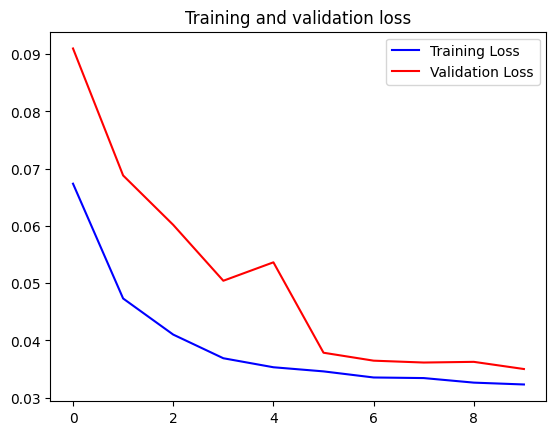

In [ ]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Fit the model
history = autoencoder.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=10,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h2', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])

# Save model
autoencoder.save('models/image_autoencoder_2.h2')

<ipython-input-12-e874a2cbf087>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


Epoch 1/10
90/90 [==============================] - 322s 4s/step - loss: 0.0595 - val_loss: 0.1141
Epoch 2/10
90/90 [==============================] - 41s 458ms/step - loss: 0.0487 - val_loss: 0.0660
Epoch 3/10
90/90 [==============================] - 42s 461ms/step - loss: 0.0440 - val_loss: 0.0570
Epoch 4/10
90/90 [==============================] - 32s 354ms/step - loss: 0.0408 - val_loss: 0.0830
Epoch 5/10
90/90 [==============================] - 32s 354ms/step - loss: 0.0386 - val_loss: 0.1688
Epoch 6/10
90/90 [==============================] - 32s 349ms/step - loss: 0.0367 - val_loss: 0.0928
Epoch 7/10
90/90 [==============================] - 39s 432ms/step - loss: 0.0356 - val_loss: 0.0381
Epoch 8/10
90/90 [==============================] - 42s 459ms/step - loss: 0.0351 - val_loss: 0.0373
Epoch 9/10
90/90 [==============================] - 32s 354ms/step - loss: 0.0342 - val_loss: 0.0431
Epoch 10/10
90/90 [==============================] - 32s 352ms/step - loss: 0.0337 - val_loss

In [ ]:
# Fit the model
history = autoencoder.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=10,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])

# Save model
autoencoder.save('models/image_autoencoder_2.h5')

<ipython-input-13-5420c2468a19>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.0689

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 959s 10s/step - loss: 0.0689 - val_loss: 0.1164
Epoch 2/10
90/90 [==============================] - 34s 380ms/step - loss: 0.0484 - val_loss: 0.0753
Epoch 3/10
90/90 [==============================] - 34s 375ms/step - loss: 0.0415 - val_loss: 0.0499
Epoch 4/10
90/90 [==============================] - 34s 378ms/step - loss: 0.0391 - val_loss: 0.0405
Epoch 5/10
90/90 [==============================] - 34s 379ms/step - loss: 0.0371 - val_loss: 0.0400
Epoch 6/10
90/90 [==============================] - 29s 318ms/step - loss: 0.0355 - val_loss: 0.0481
Epoch 7/10
90/90 [==============================] - 33s 370ms/step - loss: 0.0350 - val_loss: 0.0384
Epoch 8/10
90/90 [==============================] - 29s 319ms/step - loss: 0.0347 - val_loss: 0.0387
Epoch 9/10
90/90 [==============================] - 44s 487ms/step - loss: 0.0342 - val_loss: 0.0364
Epoch 10/10
90/90 [==============================] - 29s 318ms/step - loss: 0.0338 - val_loss: 0.0373


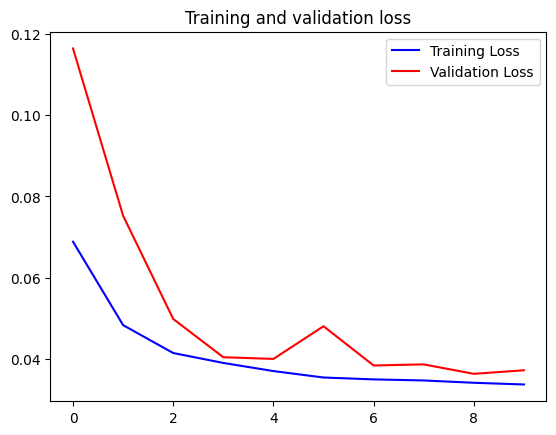

In [ ]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
os.getcwd()

'/content/gdrive/MyDrive'

In [ ]:
autoencoder = load_model('models/image_autoencoder_2.h2', compile=False)

In [ ]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(256, 256))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (256, 256, 3))
  pred = array_to_img(pred)

  return raw_image, pred

1/1 [==============================] - 0s 18ms/step


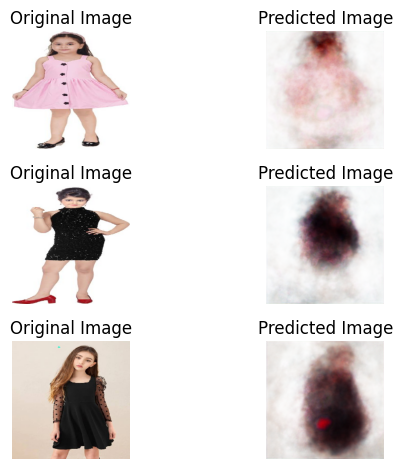

In [ ]:
# Predict 3 images from training set
# Feature vectors
train_imgs = training_set.filepaths[180:183]

fig, axs = plt.subplots(3,2)
# Loop through the images
for i, img_path in enumerate(train_imgs):
    raw_image, pred_image = predict_image(img_path, autoencoder)

    # Plot original image on the left
    axs[i, 0].imshow(raw_image)
    axs[i, 0].set_title('Original Image')

    # Plot predicted image on the right
    axs[i, 1].imshow(pred_image)
    axs[i, 1].set_title('Predicted Image')

# Remove ticks from all subplots
for ax in axs.flatten():
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined grid of subplots
plt.show()

1/1 [==============================] - 0s 20ms/step


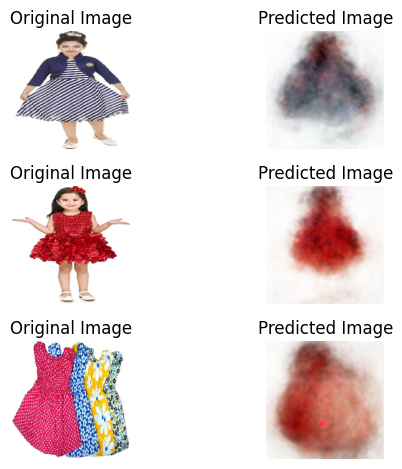

In [ ]:
# Predict 3 images from validation set
# Feature vectors
val_imgs = validation_set.filepaths[0:3]

fig, axs = plt.subplots(3,2)
# Loop through the images
for i, img_path in enumerate(val_imgs):
    raw_image, pred_image = predict_image(img_path, autoencoder)

    # Plot original image on the left
    axs[i, 0].imshow(raw_image)
    axs[i, 0].set_title('Original Image')

    # Plot predicted image on the right
    axs[i, 1].imshow(pred_image)
    axs[i, 1].set_title('Predicted Image')

# Remove ticks from all subplots
for ax in axs.flatten():
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined grid of subplots
plt.show()

In [ ]:
#Get the latent space
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

In [ ]:
# Load all images from the training set and predict them with the latent space model and store the feature vectors in embeddings
X = []
indices = []
root_dir= '/content/gdrive/MyDrive/new_train_directory'

for root, dirs, files in os.walk(root_dir):
    for img_name in files:
        try:
            img_path = os.path.join(root, img_name)
            img = load_img(img_path, target_size=(256, 256))
            img = img_to_array(img) / 255.0
            img = np.expand_dims(img, axis=0)
            pred = latent_space_model.predict(img)
            pred = np.resize(pred, (16))
            X.append(pred)
            indices.append(img_name)

    # Export the embeddings
            if i in [1,10,100,500,1000,2000]:
                embeddings = {'indices': indices, 'features': np.array(X)}

                pickle.dump(embeddings, open('./image_embeddings.pickle', 'wb'))

        except:
            print(img_name)

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Save the embeddings as dictionary with specific index
embeddings = {'indices': indices, 'features': np.array(X)}

pickle.dump(embeddings, open('image_embeddings.pickle', 'wb'))

In [ ]:
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist

def category_similarity(x,y):
  return SequenceMatcher(None, x, y).ratio()

In [ ]:
# Load embeddings
embeddings = pickle.load(open('image_embeddings.pickle', 'rb'))

In [ ]:
# list of filepaths for images in test directory

file_paths = []
root_dir ='/content/gdrive/MyDrive/Testing_directory'

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(root_dir):
    for file in files:
        # Get the full path of the file
        file_path = os.path.join(root, file)

        # Append the file path to the list
        file_paths.append(file_path)

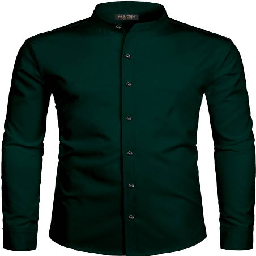

In [ ]:
# Get image name

img_path =file_paths[10]
img = load_img(img_path, target_size=(256, 256))
img


In [ ]:
# retrieving images for all the images in the test directory

# Calculate eucledian distance and arrange retrieved images in the increasing-
# order of their euclidean distance with the query image
import re
img_similarity_all_queries = {}

for img_path in file_paths:


# Get actual image embedding
  img = load_img(img_path, target_size=(256, 256))
  img = img_to_array(img) / 255.0
  img = np.expand_dims(img, axis=0)
  pred = latent_space_model.predict(img)
  pred = np.resize(pred, (16))

  img_similarity = []
  categories = []

  for i in tqdm(range(len(embeddings['indices']))):
    img_name = embeddings['indices'][i]

  # Calculate vectors distances
    dist = eucledian_distance(pred,embeddings['features'][i])
    img_similarity.append(dist)



    #for img_name in embeddings['indices']:
    # Split the file name by integers
    category = re.split(r'(\d+)', img_name)
    categories.append(category)



  imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                           })
  imgs_result['category']= categories

  imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
  imgs_result = imgs_result.iloc[0:10,:].sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
  img_similarity_all_queries[img_path] = imgs_result



1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<ipython-input-31-3f64b0d6bb16>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

In [ ]:
img_similarity_all_queries

{"/content/gdrive/MyDrive/Testing_directory/Men's_Shirts/formal shirts20_66.jpg":                      img  euclidean_distance                     category
 0   Formal Shirts 22.jpg         1198.532471   [Formal Shirts , 22, .jpg]
 1  Formal Shirts 131.jpg         1752.096191  [Formal Shirts , 131, .jpg]
 2   Formal Shirts 68.jpg         1832.155640   [Formal Shirts , 68, .jpg]
 3   Formal Shirts 82.jpg         1835.384521   [Formal Shirts , 82, .jpg]
 4    Formal Shirts 7.jpg         2005.482788    [Formal Shirts , 7, .jpg]
 5  Formal Shirts 166.jpg         2014.216919  [Formal Shirts , 166, .jpg]
 6  Formal Shirts 101.jpg         2170.302979  [Formal Shirts , 101, .jpg]
 7  Formal Shirts 147.jpg         2234.158691  [Formal Shirts , 147, .jpg]
 8  Formal Shirts 206.jpg         2241.307129  [Formal Shirts , 206, .jpg]
 9  Formal Shirts 191.jpg         2288.428711  [Formal Shirts , 191, .jpg],
 "/content/gdrive/MyDrive/Testing_directory/Men's_Shirts/formal shirts 8_21.jpg":            

In [ ]:
os.getcwd()

'/content/gdrive/MyDrive'

In [ ]:
import pickle

# Save the dictionary to a file
with open('img_similarity_data.pkl', 'wb') as f:
    pickle.dump(img_similarity_all_queries, f)

In [ ]:
import pickle

# Load the dictionary from the file
with open('img_similarity_data.pkl', 'rb') as f:
    img_similarity_all_queries = pickle.load(f)

# Now, 'loaded_img_similarity_all_queries' contains the dictionary loaded from the file


In [ ]:
categories

[['formal shirts ', '15', '_', '3', '.jpg']]

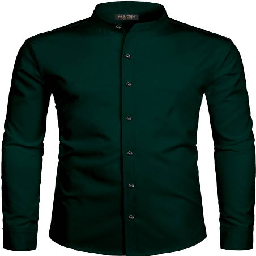

In [ ]:
img_path =file_paths[10]
img = load_img(img_path, target_size=(256, 256))
img

1/1 [==============================] - 0s 18ms/step


<ipython-input-13-2f9e883ca507>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

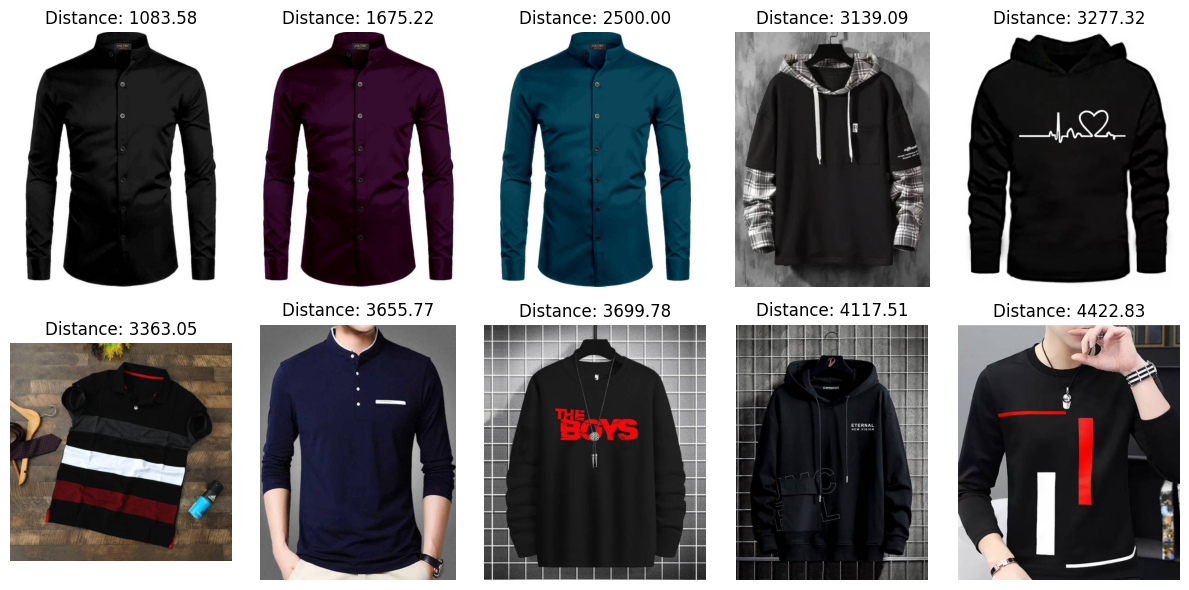

In [ ]:
# Calculate eucledian distance
img_similarity = []

# Get actual image embedding
img = load_img(img_path, target_size=(256, 256))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity


imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                           })


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < 10:
        image_filename = imgs_result['img'].values[i]  # Get the image filename
        image_filename = imgs_result['img'].values[i]  # Get the image filename

    # Iterate through subdirectories to find the image
        for root, dirs, files in os.walk('/content/gdrive/MyDrive/new_train_directory'):
          for file in files:
            if file == image_filename:
                image_path = os.path.join(root, file)
                image = load_img(image_path)


  # Show image
                # Show image in the current subplot
                ax.imshow(image)
                ax.set_title(f'Distance: {imgs_result["euclidean_distance"].values[i]:.2f}')
                ax.axis('off')
                break

                print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))

plt.tight_layout()
plt.show()

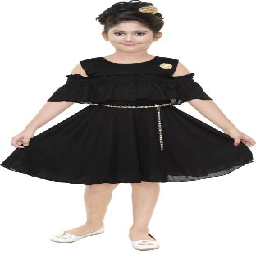

In [ ]:
#Query image
img_path = file_paths[112]
img = load_img(img_path, target_size=(256, 256))
img


1/1 [==============================] - 0s 19ms/step


<ipython-input-25-2f9e883ca507>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

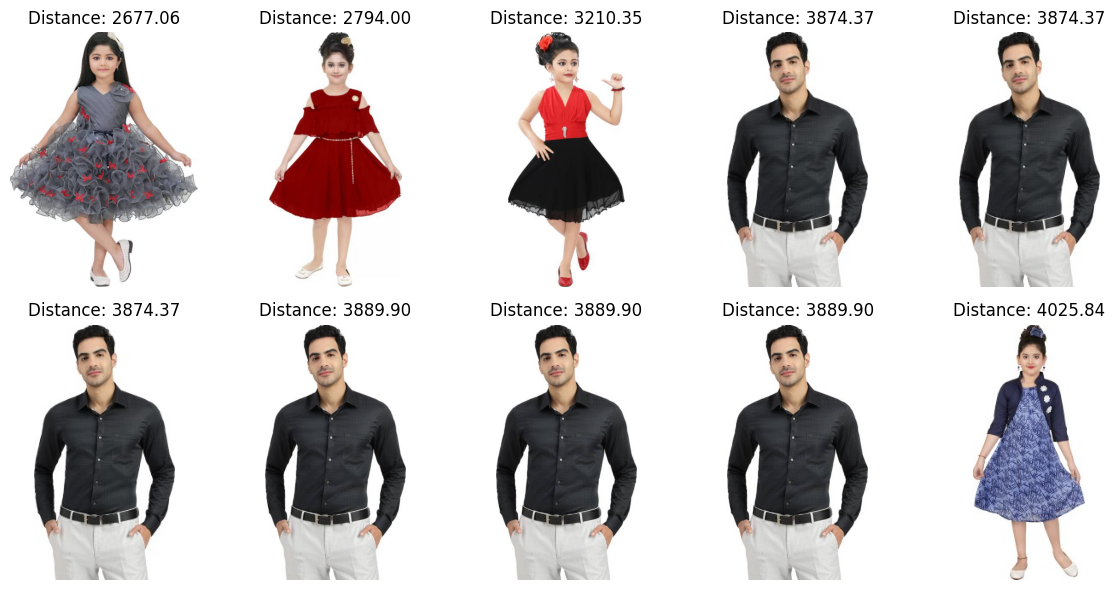

In [ ]:
# Calculate eucledian distance
img_similarity = []

# Get actual image embedding
img = load_img(img_path, target_size=(256, 256))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity


imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                           })


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < 10:
        image_filename = imgs_result['img'].values[i]  # Get the image filename
        image_filename = imgs_result['img'].values[i]  # Get the image filename

    # Iterate through subdirectories to find the image
        for root, dirs, files in os.walk('/content/gdrive/MyDrive/new_train_directory'):
          for file in files:
            if file == image_filename:
                image_path = os.path.join(root, file)
                image = load_img(image_path)


  # Show image
                # Show image in the current subplot
                ax.imshow(image)
                ax.set_title(f'Distance: {imgs_result["euclidean_distance"].values[i]:.2f}')
                ax.axis('off')
                break

                print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))

plt.tight_layout()
plt.show()

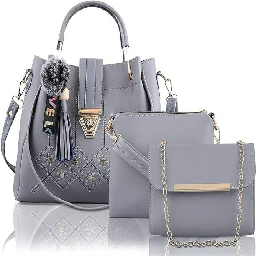

In [ ]:
#Query image
img_path =file_paths[252]
img = load_img(img_path, target_size=(256, 256))
img


1/1 [==============================] - 0s 20ms/step


<ipython-input-46-2f9e883ca507>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

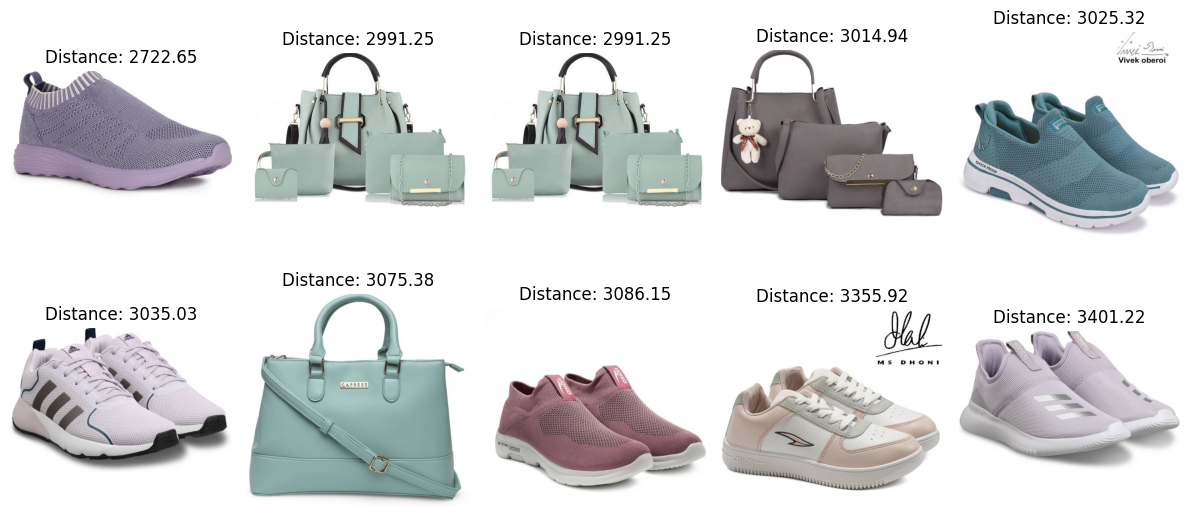

In [ ]:
# Calculate eucledian distance
img_similarity = []

# Get actual image embedding
img = load_img(img_path, target_size=(256, 256))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity


imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                           })


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < 10:
        image_filename = imgs_result['img'].values[i]  # Get the image filename
        image_filename = imgs_result['img'].values[i]  # Get the image filename

    # Iterate through subdirectories to find the image
        for root, dirs, files in os.walk('/content/gdrive/MyDrive/new_train_directory'):
          for file in files:
            if file == image_filename:
                image_path = os.path.join(root, file)
                image = load_img(image_path)


  # Show image
                # Show image in the current subplot
                ax.imshow(image)
                ax.set_title(f'Distance: {imgs_result["euclidean_distance"].values[i]:.2f}')
                ax.axis('off')
                break

                print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))

plt.tight_layout()
plt.show()

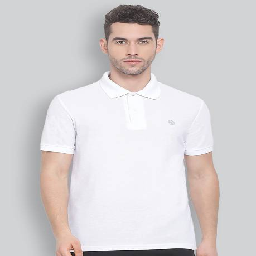

In [ ]:
#Query image
img_path =file_paths[300]
img = load_img(img_path, target_size=(256, 256))
img

1/1 [==============================] - 0s 18ms/step


<ipython-input-32-2f9e883ca507>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

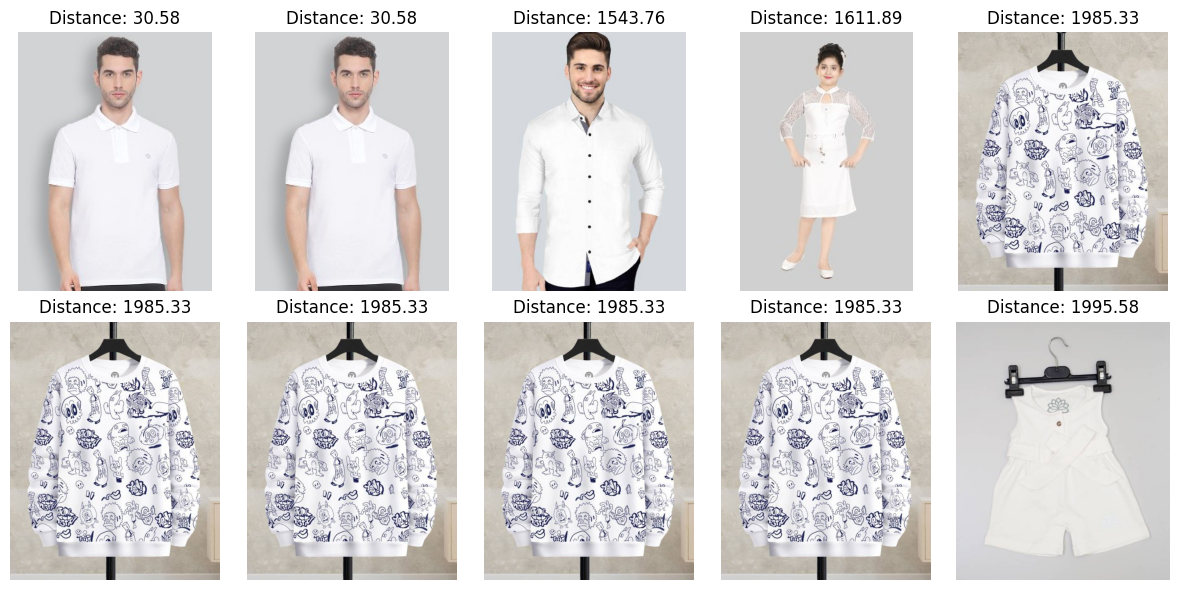

In [ ]:
# Calculate eucledian distance
img_similarity = []

# Get actual image embedding
img = load_img(img_path, target_size=(256, 256))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity


imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                           })


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < 10:
        image_filename = imgs_result['img'].values[i]  # Get the image filename
        image_filename = imgs_result['img'].values[i]  # Get the image filename

    # Iterate through subdirectories to find the image
        for root, dirs, files in os.walk('/content/gdrive/MyDrive/new_train_directory'):
          for file in files:
            if file == image_filename:
                image_path = os.path.join(root, file)
                image = load_img(image_path)


  # Show image
                # Show image in the current subplot
                ax.imshow(image)
                ax.set_title(f'Distance: {imgs_result["euclidean_distance"].values[i]:.2f}')
                ax.axis('off')
                break

                print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))

plt.tight_layout()
plt.show()

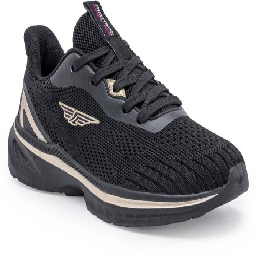

In [ ]:
#Query image
img_path =file_paths[190]
img = load_img(img_path, target_size=(256, 256))
img

1/1 [==============================] - 0s 19ms/step


<ipython-input-42-2f9e883ca507>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/1448 [00:00<?, ?it/s]

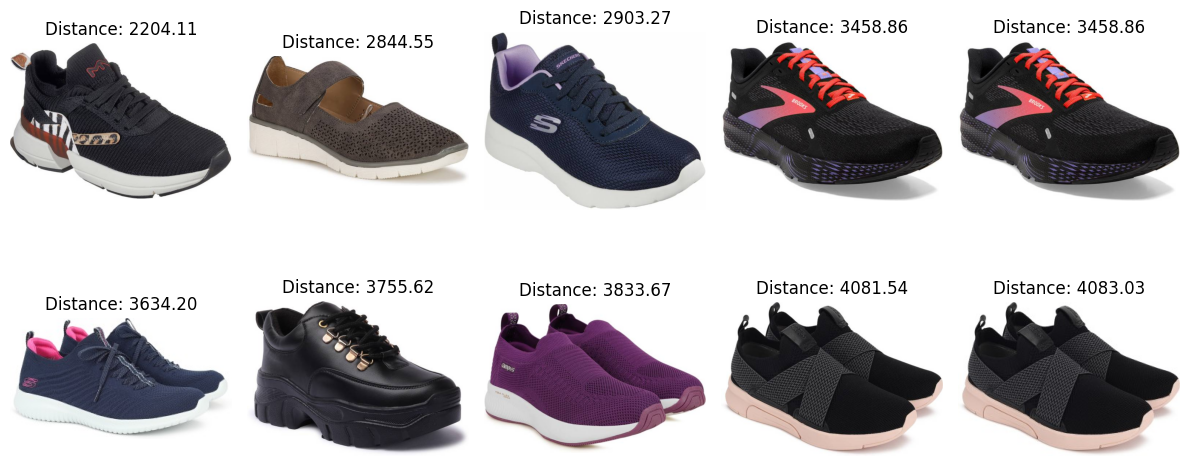

In [ ]:
# Calculate eucledian distance
img_similarity = []

# Get actual image embedding
img = load_img(img_path, target_size=(256, 256))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity


imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                           })


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < 10:
        image_filename = imgs_result['img'].values[i]  # Get the image filename
        image_filename = imgs_result['img'].values[i]  # Get the image filename

    # Iterate through subdirectories to find the image
        for root, dirs, files in os.walk('/content/gdrive/MyDrive/new_train_directory'):
          for file in files:
            if file == image_filename:
                image_path = os.path.join(root, file)
                image = load_img(image_path)


  # Show image
                # Show image in the current subplot
                ax.imshow(image)
                ax.set_title(f'Distance: {imgs_result["euclidean_distance"].values[i]:.2f}')
                ax.axis('off')
                break

                print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))

plt.tight_layout()
plt.show()